# LANL Earthquake Prediction Kaggle Competition 2019
### Eric Yap, Joel Huang, Kyra Wang

---

In this notebook, we present our work for the LANL Earthquake Prediction Kaggle Competition 2019. The goal of this competition is to use seismic signals to predict the timing of laboratory earthquakes. The data comes from a well-known experimental set-up used to study earthquake physics. The `acoustic_data` input signal is used to predict the time remaining before the next laboratory earthquake (`time_to_failure`).

The training data is a single, continuous segment of experimental data. The test data consists of a folder containing many small segments. The data within each test file is continuous, but the test files do not represent a continuous segment of the experiment; thus, the predictions cannot be assumed to follow the same regular pattern seen in the training file.

For each `seg_id` in the test folder, we need to predict a single `time_to_failure` corresponding to the time between the last row of the segment and the next laboratory earthquake.

---

### Imports

In [1]:
from __future__ import print_function, division, absolute_import

# Data wrangling imports
import numpy as np
import pandas as pd
from scipy import signal
from sklearn.preprocessing import StandardScaler

# Utility imports
import os
import os.path
import time
import math
import ast
import copy
from collections import OrderedDict
from datetime import datetime
from tqdm import tqdm
from joblib import Parallel, delayed

# Data visualization imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import seaborn as sns

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter
from torch.nn.utils import weight_norm
from torch.autograd import Variable, Function
import torch.optim as optim
import torch.utils.data as data
import torch.utils.checkpoint as cp
from torchvision import transforms
from torchsummary import summary

# Our own utility code
from utils.lr_finder import LRFinder
from utils.lanl_data import LANL_FeatureGenerator, LANL_Dataset, LANL_Dataset_LR

In [2]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

print(torch.cuda.get_device_name(device))

torch.backends.cudnn.benchmark = True

# Setting the seeds for reproducibility
np.random.seed(42)
if use_cuda:
    torch.cuda.manual_seed_all(42)
else:
    torch.manual_seed_all(42)

Tesla P4


### Data preprocessing

As the training data and the test data are formatted differently, we must either preprocess the data such that the formats of both sets are the same, or ensure that our model is capable of predicting on the two different formats. We went with the first option because it is less time consuming to implement.

We did this by splitting the training data into segments the same size as the test data segments, i.e. 150000 data points each. Each segment is labeled with a single `time_to_failure` corresponding to the time between the last row of the segment and the next laboratory earthquake. We then put each of these segments into a single dataframe, and saved this as a pickle file to be used as our training data.

Following this, we merged the separate test segments into another single dataframe, and saved this as a pickle file to be used as our test data.

As the dataset is massive, we used `Joblib` to help run the functions as a pipeline jobs with parallel computing. The feature extraction code is in `./utils/lanl_data.py`.

In [3]:
# !pip install kaggle
# !mkdir ./data
# !kaggle competitions download -p ./data -c LANL-Earthquake-Prediction

# !unzip ./data/train.csv.zip -d ./data
# !mkdir ./data/test
# !unzip ./data/test.zip -d ./data/test

# !chmod 644 ./data/train.csv
# !find ./data/test -type f -exec chmod 644 {} \;

In [4]:
training_fg = LANL_FeatureGenerator(dtype='train', n_jobs=16, chunk_size=150000)
training_data = training_fg.generate()

test_fg = LANL_FeatureGenerator(dtype='test', n_jobs=16, chunk_size=None)
test_data = test_fg.generate()

training_data.to_pickle('./data/train_features.pkl')
test_data.to_pickle('./data/test_features.pkl')

4195it [02:12, 31.72it/s]                          
100%|██████████| 2624/2624 [00:30<00:00, 84.69it/s]


In [3]:
trainval_df = pd.read_pickle('./data/train_features.pkl')
trainval_df = trainval_df[trainval_df.segment.map(len) == 150000]

trainval_df.head()

,seg_id,segment,target
0,train_0,"[12, 6, 8, 5, 8, 8, 9, 7, -5, 3, 5, 2, 2, 3, -...",1.430797
1,train_1,"[5, 6, 8, 6, 3, -1, 5, 4, 4, 4, 6, 5, 5, 5, 6,...",1.391499
2,train_2,"[5, 5, 8, 9, 9, 10, 11, 12, 13, 5, 3, 7, 5, 3,...",1.353196
3,train_3,"[5, -5, -4, 1, 3, 4, 6, 12, 15, 17, 14, 9, 6, ...",1.313798
4,train_4,"[12, 6, 4, -1, 0, 6, 7, 6, 2, -2, 0, 4, 1, 5, ...",1.274400


In [4]:
test_df = pd.read_pickle('./data/test_features.pkl')

test_df.head()

,seg_id,segment,target
0,seg_00030f,"[4, 0, -2, 0, 2, -3, -9, -4, 11, 11, 8, 1, 10,...",-999
1,seg_0012b5,"[5, 8, 8, 7, 4, 1, -1, -4, -1, 0, 5, 7, -1, 7,...",-999
2,seg_00184e,"[8, 2, 3, 8, 7, 9, 7, 4, 4, 9, 9, 1, 2, 6, 4, ...",-999
3,seg_003339,"[2, 6, 3, 6, 8, 6, 8, 5, 4, 6, 2, 3, 1, 4, 6, ...",-999
4,seg_0042cc,"[5, 3, 1, 4, 6, 6, 7, 4, 5, 4, 3, 4, 6, 7, 3, ...",-999


At this point, we split the training data further into a 80/20 training/validation split. We then create dataloaders that will help load the data into the model in parallel using multiprocessing workers.

In [5]:
msk = np.random.rand(len(trainval_df)) < 0.8
train_df = trainval_df[msk]
valid_df = trainval_df[~msk]

train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

print('Training data is {} of the data'.format(len(train_df)/len(trainval_df)))

Training data is 0.8001907486886027 of the data


In [6]:
scaler = StandardScaler()

scaler.fit(np.concatenate(train_df.segment.values).astype(float).reshape(-1, 1))
train_df.segment = train_df.segment.map(lambda x: scaler.transform(x.astype(float).reshape(-1, 1)).flatten())
valid_df.segment = valid_df.segment.map(lambda x: scaler.transform(x.astype(float).reshape(-1, 1)).flatten())
test_df.segment = test_df.segment.map(lambda x: scaler.transform(x.astype(float).reshape(-1, 1)).flatten())

In [7]:
train_df.head()

,seg_id,segment,target
0,train_0,"[0.6853687744937642, 0.13560972945236838, 0.31...",1.430797
1,train_2,"[0.04398322194546909, 0.04398322194546909, 0.3...",1.353196
2,train_3,"[0.04398322194546909, -0.8722818531235239, -0....",1.313798
3,train_4,"[0.6853687744937642, 0.13560972945236838, -0.0...",1.274400
4,train_5,"[0.8686217895075627, 0.22723623695926767, 0.31...",1.236097


### Defining the Model

In [8]:
def _bn_function_factory(norm, relu, conv):
    def bn_function(*inputs):
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = conv(relu(norm(concated_features)))
        return bottleneck_output

    return bn_function


class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, efficient=False):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm1d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv1d(num_input_features, bn_size * growth_rate,
                        kernel_size=1, stride=1, bias=False)),
        self.add_module('norm2', nn.BatchNorm1d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv1d(bn_size * growth_rate, growth_rate,
                        kernel_size=3, stride=1, padding=1, bias=False)),
        self.drop_rate = drop_rate
        self.efficient = efficient

    def forward(self, *prev_features):
        bn_function = _bn_function_factory(self.norm1, self.relu1, self.conv1)
        if self.efficient and any(prev_feature.requires_grad for prev_feature in prev_features):
            bottleneck_output = cp.checkpoint(bn_function, *prev_features)
        else:
            bottleneck_output = bn_function(*prev_features)
        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return new_features


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm1d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv1d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool1d(kernel_size=2, stride=2))


class _DenseBlock(nn.Module):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, efficient=False):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                efficient=efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.named_children():
            new_features = layer(*features)
            features.append(new_features)
        return torch.cat(features, 1)


class DenseNet(nn.Module):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`
    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 3 or 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
            (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
        small_inputs (bool) - set to True if images are 32x32. Otherwise assumes images are larger.
        efficient (bool) - set to True to use checkpointing. Much more memory efficient, but slower.
    """
    def __init__(self, growth_rate=48, block_config=(6, 6, 6), compression=0.5,
                 num_init_features=24, bn_size=4, drop_rate=0.5,
                 num_classes=1, small_inputs=False, efficient=True):

        super(DenseNet, self).__init__()
        assert 0 < compression <= 1, 'compression of densenet should be between 0 and 1'
        self.avgpool_size = 8 if small_inputs else 7

        # First convolution
        if small_inputs:
            self.features = nn.Sequential(OrderedDict([
                ('conv0', nn.Conv1d(1, num_init_features, kernel_size=3, stride=1, padding=1, bias=False)),
            ]))
        else:
            self.features = nn.Sequential(OrderedDict([
                ('conv0', nn.Conv1d(1, num_init_features, kernel_size=51, stride=40, padding=25, bias=False)),
            ]))
            self.features.add_module('norm0', nn.BatchNorm1d(num_init_features))
            self.features.add_module('relu0', nn.ReLU(inplace=True))
            self.features.add_module('pool0', nn.MaxPool1d(kernel_size=3, stride=2, padding=1,
                                                           ceil_mode=False))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                efficient=efficient,
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=int(num_features * compression))
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = int(num_features * compression)

        # Final batch norm
        self.features.add_module('norm_final', nn.BatchNorm1d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Initialization
        for name, param in self.named_parameters():
            if 'conv' in name and 'weight' in name:
                n = param.size(0) * param.size(2)
                param.data.normal_().mul_(math.sqrt(2. / n))
            elif 'norm' in name and 'weight' in name:
                param.data.fill_(1)
            elif 'norm' in name and 'bias' in name:
                param.data.fill_(0)
            elif 'classifier' in name and 'bias' in name:
                param.data.fill_(0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool1d(out, 1).view(features.size(0), -1)
        out = self.classifier(out)
        return out

In [9]:
model = DenseNet().to(device)
summary(model, (1, 150000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 24, 3750]           1,224
       BatchNorm1d-2             [-1, 24, 3750]              48
              ReLU-3             [-1, 24, 3750]               0
         MaxPool1d-4             [-1, 24, 1875]               0
       BatchNorm1d-5             [-1, 24, 1875]              48
              ReLU-6             [-1, 24, 1875]               0
            Conv1d-7            [-1, 192, 1875]           4,608
       BatchNorm1d-8            [-1, 192, 1875]             384
              ReLU-9            [-1, 192, 1875]               0
           Conv1d-10             [-1, 48, 1875]          27,648
      _DenseLayer-11             [-1, 48, 1875]               0
      BatchNorm1d-12             [-1, 72, 1875]             144
             ReLU-13             [-1, 72, 1875]               0
           Conv1d-14            [-1, 19

In [7]:
class LANL_Ressubblock(nn.Module):
    
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 padding):
        super(LANL_Ressubblock, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding)
        self.bn = nn.BatchNorm1d(out_channels)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x
    

class LANL_Resblock(nn.Module):
    
    def __init__(self,
                 in_channels,
                 out_channels):
        super(LANL_Resblock, self).__init__()
        
        self.subblocks = nn.Sequential(
            LANL_Ressubblock(in_channels, out_channels, 7, 3),
            nn.ReLU(),
            LANL_Ressubblock(out_channels, out_channels, 5, 2),
            nn.ReLU(),
            LANL_Ressubblock(out_channels, out_channels, 3, 1)
        )
        
        if (in_channels != out_channels):
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, 1),
                nn.BatchNorm1d(out_channels)
            )
        else:
            self.shortcut = nn.BatchNorm1d(out_channels)

        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = self.subblocks(x)
        x2 = self.shortcut(x)
        x = x1 + x2
        x = self.relu(x)
        return x
    
    
class LANL_Resnext(nn.Module):
    
    def __init__(self,
                 n_output=1):
        
        super(LANL_Resnext, self).__init__()
        self.blocks = nn.Sequential(
            LANL_Resblock(1, 64),
            LANL_Resblock(64, 128),
            LANL_Resblock(128, 128)
        )
        
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(128, n_output)

    def forward(self, x):
        x = self.blocks(x)
        x = self.gap(x).squeeze(-1)
        x = self.fc(x)
        return x

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


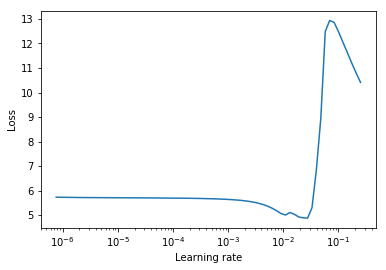

In [16]:
# Parameters
params = {'batch_size': 32,
          'shuffle': True,
          'num_workers': 8}

model = DenseNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=0.01, amsgrad=True)
criterion = nn.L1Loss()
train_dataloader_lr = data.DataLoader(LANL_Dataset_LR(train_df), **params)
valid_dataloader_lr = data.DataLoader(LANL_Dataset_LR(valid_df), **params)

lr_find = LRFinder(model, optimizer, criterion)
lr_find.range_test(train_dataloader_lr, val_loader=valid_dataloader_lr)
lr_find.plot()
lr_find.reset()

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


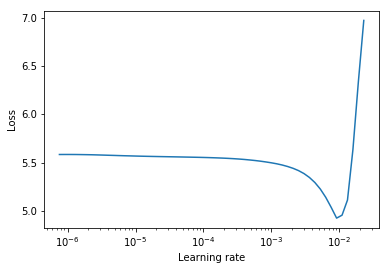

In [17]:
# Parameters
params = {'batch_size': 32,
          'shuffle': True,
          'num_workers': 8}

model = DenseNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=0.01)
criterion = nn.L1Loss()
train_dataloader_lr = data.DataLoader(LANL_Dataset_LR(train_df), **params)
valid_dataloader_lr = data.DataLoader(LANL_Dataset_LR(valid_df), **params)

lr_find = LRFinder(model, optimizer, criterion)
lr_find.range_test(train_dataloader_lr, val_loader=valid_dataloader_lr)
lr_find.plot()
lr_find.reset()

In [9]:
def LANL_train(model,
               dataloaders,
               optimizer,
               criterion=nn.L1Loss(),
               num_epochs=1000,
               patience=200,
               snapshot_path='./snapshots',
               model_path='./models'):
    
    train_loss_hist = []
    valid_loss_hist = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = -1
    
    early_stopping = False
    early_stopping_count = 0
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=5, min_lr=1e-4, factor=0.5)
    
    for epoch in range(num_epochs):
        if not early_stopping:
            print('Epoch {}/{}'.format(epoch + 1, num_epochs))
            print('-' * 10)

            for phase in ['train', 'valid']:
                if phase == 'train':
                    model.train()
                if phase == 'valid':
                    model.eval()

                running_loss = 0.0
                
                for idx, sample in enumerate(tqdm(dataloaders[phase], total=len(dataloaders[phase]))):
                    X, y = sample['X'].float().to(device), sample['y'].float().to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        output = model(X)
                        loss = criterion(output, y)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * X.size(0)

                epoch_loss = running_loss/len(dataloaders[phase].dataset)

                print('{} loss: {:.6f}'.format(phase, epoch_loss))

                if phase == 'train':
                    train_loss_hist.append(epoch_loss)
                if phase == 'valid':
                    valid_loss_hist.append(epoch_loss)
                    scheduler.step(epoch_loss)
                    datetime_str = datetime.now().strftime("%Y%m%d-%H%M%S")
                    torch.save(copy.deepcopy(model.state_dict()), snapshot_path + '/snapshot_' + datetime_str + '_' + str(epoch_loss) + '.pt')
                    for param_group in optimizer.param_groups:
                        print(param_group['lr'])
                    if epoch_loss < best_loss or best_loss == -1:
                        early_stopping_count = 0
                        best_loss = epoch_loss
                        best_model_wts = copy.deepcopy(model.state_dict())
                    else:
                        early_stopping_count += 1
                        print('Early stopping count at {} of {}'.format(early_stopping_count, patience))
                        if early_stopping_count >= patience:
                            early_stopping = True
                            print('Out of patience, early stopping training')
            
            print()

    print('Best validation loss: {:6f}'.format(best_loss))
    
    model.load_state_dict(best_model_wts)
    datetime_str = datetime.now().strftime("%Y%m%d-%H%M%S")
    torch.save(best_model_wts, model_path + '/model_' + datetime_str + '_' + str(best_loss) + '.pt')
    
    return model, train_loss_hist, valid_loss_hist

In [10]:
# Parameters
params = {'batch_size': 32,
          'shuffle': True,
          'num_workers': 8}

datasets = {'train': LANL_Dataset(train_df),
            'valid': LANL_Dataset(valid_df),
            'test' : LANL_Dataset(test_df )}

dataloaders = {phase: data.DataLoader(dataset, **params) for phase, dataset in datasets.items()}

In [11]:
model = DenseNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=7e-3, weight_decay=0.01)

model, train_loss_hist, valid_loss_hist = LANL_train(model, dataloaders, optimizer)

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 1/1000
----------


  0%|          | 0/27 [00:00<?, ?it/s]

train loss: 2.375641


  0%|          | 0/105 [00:00<?, ?it/s]

valid loss: 4.635597
0.007

Epoch 2/1000
----------


  0%|          | 0/27 [00:00<?, ?it/s]

train loss: 2.164660


  0%|          | 0/105 [00:00<?, ?it/s]

valid loss: 3.865378
0.007

Epoch 3/1000
----------


  0%|          | 0/27 [00:00<?, ?it/s]

train loss: 2.142765


  0%|          | 0/105 [00:00<?, ?it/s]

valid loss: 2.271651
0.007

Epoch 4/1000
----------


  0%|          | 0/27 [00:00<?, ?it/s]

train loss: 2.116709


  0%|          | 0/105 [00:00<?, ?it/s]

valid loss: 2.627254
0.007
Early stopping count at 1 of 200

Epoch 5/1000
----------


  0%|          | 0/27 [00:00<?, ?it/s]

train loss: 2.121433


  0%|          | 0/105 [00:00<?, ?it/s]

valid loss: 5.806313
0.007
Early stopping count at 2 of 200

Epoch 6/1000
----------


  0%|          | 0/27 [00:00<?, ?it/s]

train loss: 2.133841


  0%|          | 0/105 [00:00<?, ?it/s]

valid loss: 2.392038
0.007
Early stopping count at 3 of 200

Epoch 7/1000
----------


  0%|          | 0/27 [00:00<?, ?it/s]

train loss: 2.143413


  0%|          | 0/105 [00:00<?, ?it/s]

valid loss: 5.974848
0.007
Early stopping count at 4 of 200

Epoch 8/1000
----------


  0%|          | 0/27 [00:00<?, ?it/s]

train loss: 2.137327


  0%|          | 0/105 [00:00<?, ?it/s]

valid loss: 4.249225
0.007
Early stopping count at 5 of 200

Epoch 9/1000
----------


  0%|          | 0/27 [00:00<?, ?it/s]

train loss: 2.113655


  0%|          | 0/105 [00:00<?, ?it/s]

valid loss: 2.204766
0.007

Epoch 10/1000
----------


  0%|          | 0/27 [00:00<?, ?it/s]

train loss: 2.106119


  0%|          | 0/105 [00:00<?, ?it/s]

valid loss: 2.360807
0.007
Early stopping count at 1 of 200

Epoch 11/1000
----------


  0%|          | 0/27 [00:00<?, ?it/s]

train loss: 2.128963


  0%|          | 0/105 [00:00<?, ?it/s]

valid loss: 3.975092
0.007
Early stopping count at 2 of 200

Epoch 12/1000
----------


  0%|          | 0/27 [00:00<?, ?it/s]

train loss: 2.105575


  0%|          | 0/105 [00:00<?, ?it/s]

valid loss: 2.340441
0.007
Early stopping count at 3 of 200

Epoch 13/1000
----------


  0%|          | 0/27 [00:00<?, ?it/s]

train loss: 2.126262


  0%|          | 0/105 [00:00<?, ?it/s]

valid loss: 6.067482
0.007
Early stopping count at 4 of 200

Epoch 14/1000
----------


  0%|          | 0/27 [00:00<?, ?it/s]

train loss: 2.108446


  0%|          | 0/105 [00:00<?, ?it/s]

valid loss: 6.667608
0.007
Early stopping count at 5 of 200

Epoch 15/1000
----------


  0%|          | 0/27 [00:00<?, ?it/s]

train loss: 2.111650


  0%|          | 0/105 [00:00<?, ?it/s]

valid loss: 4.270227
Epoch    14: reducing learning rate of group 0 to 3.5000e-03.
0.0035
Early stopping count at 6 of 200

Epoch 16/1000
----------


  0%|          | 0/27 [00:00<?, ?it/s]

train loss: 2.110845


  0%|          | 0/105 [00:00<?, ?it/s]

valid loss: 6.340066
0.0035
Early stopping count at 7 of 200

Epoch 17/1000
----------


  0%|          | 0/27 [00:00<?, ?it/s]

train loss: 2.102946


  0%|          | 0/105 [00:00<?, ?it/s]

valid loss: 5.947736
0.0035
Early stopping count at 8 of 200

Epoch 18/1000
----------


  0%|          | 0/27 [00:00<?, ?it/s]

train loss: 2.079277


  0%|          | 0/105 [00:00<?, ?it/s]

valid loss: 6.282339
0.0035
Early stopping count at 9 of 200

Epoch 19/1000
----------


  0%|          | 0/27 [00:00<?, ?it/s]

train loss: 2.092346


  0%|          | 0/105 [00:00<?, ?it/s]

valid loss: 5.726004
0.0035
Early stopping count at 10 of 200

Epoch 20/1000
----------


  0%|          | 0/27 [00:00<?, ?it/s]

train loss: 2.084884


  0%|          | 0/105 [00:00<?, ?it/s]

valid loss: 5.879826
0.0035
Early stopping count at 11 of 200

Epoch 21/1000
----------


  0%|          | 0/27 [00:00<?, ?it/s]

train loss: 2.097024


  0%|          | 0/105 [00:00<?, ?it/s]

valid loss: 6.085698
Epoch    20: reducing learning rate of group 0 to 1.7500e-03.
0.00175
Early stopping count at 12 of 200

Epoch 22/1000
----------


  0%|          | 0/27 [00:00<?, ?it/s]

train loss: 2.076858


  0%|          | 0/105 [00:00<?, ?it/s]

valid loss: 6.285226
0.00175
Early stopping count at 13 of 200

Epoch 23/1000
----------


  0%|          | 0/27 [00:00<?, ?it/s]

train loss: 2.068019


  0%|          | 0/105 [00:00<?, ?it/s]

valid loss: 6.336741
0.00175
Early stopping count at 14 of 200

Epoch 24/1000
----------


  0%|          | 0/27 [00:00<?, ?it/s]

train loss: 2.071516


  0%|          | 0/105 [00:00<?, ?it/s]

valid loss: 6.228136
0.00175
Early stopping count at 15 of 200

Epoch 25/1000
----------


  0%|          | 0/27 [00:00<?, ?it/s]

train loss: 2.071750


  0%|          | 0/105 [00:00<?, ?it/s]

valid loss: 6.492934
0.00175
Early stopping count at 16 of 200

Epoch 26/1000
----------


  0%|          | 0/27 [00:00<?, ?it/s]

train loss: 2.067669


  0%|          | 0/105 [00:00<?, ?it/s]

valid loss: 6.219102
0.00175
Early stopping count at 17 of 200

Epoch 27/1000
----------


  0%|          | 0/27 [00:00<?, ?it/s]

train loss: 2.054010


  0%|          | 0/105 [00:00<?, ?it/s]

valid loss: 6.159574
Epoch    26: reducing learning rate of group 0 to 8.7500e-04.
0.000875
Early stopping count at 18 of 200

Epoch 28/1000
----------


 27%|██▋       | 28/105 [00:11<00:27,  2.79it/s]

KeyboardInterrupt: 

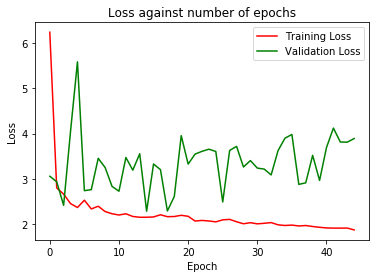

In [40]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss against number of epochs')
ax1.plot(train_loss_hist, 'r', label='Training Loss')
ax1.plot(valid_loss_hist, 'g', label='Validation Loss')
ax1.legend()

plt.show()

### Evaluating the model on the test data

In [12]:
def LANL_test(model,
              dataloaders,
              submission_path='./submissions'):
    predictions = {'seg_id': [], 'time_to_failure': []}
    model.eval()
    with torch.no_grad():
        for idx, sample in enumerate(dataloaders['test']):
                seg_id, X = sample['seg_id'], sample['X'].float().to(device)
                output = model(X)
                for i in range(X.size(0)):
                    predictions['seg_id'].append(seg_id[i])
                    predictions['time_to_failure'].append(output[i].item())
    df = pd.DataFrame.from_dict(predictions)
    datetime_str = datetime.now().strftime("%Y%m%d-%H%M%S")
    df.to_csv(submission_path + '/submission_' + datetime_str + '.csv', index=False)
    return df

In [14]:
model.load_state_dict(torch.load('./snapshots/snapshot_20190423-011317_2.2047657212664804.pt'))
predictions = LANL_test(model, dataloaders)
predictions.head()

,seg_id,time_to_failure
0,seg_1ef708,3.977185
1,seg_90e904,2.990410
2,seg_90bf60,9.229366
3,seg_7428e7,5.619104
4,seg_afa4a1,7.786890
